In [1]:
#!python.exe -m pip install --upgrade pip
!pip install imparaai-checkers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from checkers.game import Game

In [3]:
class Heuristics:
    @staticmethod
    def get_player_pieces(game, player):
        player_pieces = []
        for piece in game.board.pieces:
            if piece.player == player and not piece.captured:
                player_pieces.append(piece)
        return player_pieces
    
    @staticmethod
    def get_opponent_pieces(game, player):
        opponent_pieces = []
        for piece in game.board.pieces:
            if piece.player != player and not piece.captured:
                opponent_pieces.append(piece)
        return opponent_pieces
    
    #heuristics list starts here
    #increase the number of pieces of the player as much as possible, maximize the difference between the player and opponent
    @staticmethod
    def simple_piece_count(game, player):
        player_pieces = Heuristics.get_player_pieces(game, player)
        opponent_pieces = Heuristics.get_opponent_pieces(game, player)
        
        return len(player_pieces) - len(opponent_pieces)
    
    #try to increase the number of king pieces the player has
    @staticmethod
    def king_count(game, player):
        player_pieces = Heuristics.get_player_pieces(game, player)
        return sum(1 for piece in player_pieces if piece.king)
    
    #try to have as much as dominance possible in the centre board
    @staticmethod
    def evaluate_board_control(game, player):
        #Higher score for central squares, Medium score for middle squares, lower score for back rows
        board_control_scores = {
            (1, 2, 3, 4, 5, 6, 7, 8): 5,  
            (9, 10, 11, 12, 21, 22, 23, 24): 3,  
            (13, 14, 15, 16, 17, 18, 19, 20): 1, 
        }

        total_score = 0
        # Use a set to collect unique positions
        total_positions = set()  
        
        pieces = Heuristics.get_player_pieces(game, player)
        
        for piece in pieces:
            for positions, score in board_control_scores.items():
                if piece.position in positions:
                    total_score += score
                    # Add the positions in the group to the set
                    total_positions.update(positions)
                    # Assign the highest available score  
                    break  

        return total_score
    #heuristics list ends here    

In [4]:
import copy

class MinimaxAgent:
    def __init__(self, player):
        self.player = player

    def get_best_move(self, game, heuristic):
        _, best_move = self.minimax(game, 4, True, float('-inf'), float('inf'), heuristic)
        return best_move

    def minimax(self, game, depth, maximizing_player, alpha, beta, heuristic):
        #selection of the heuristics for position evaluation when either the game is over or at the leaf nodes
        if depth == 0 or game.is_over():
            if heuristic == "piece_count":
                return Heuristics.simple_piece_count(game, self.player), None
            elif heuristic == "king_count":
                return Heuristics.king_count(game, self.player), None
            else:
                return Heuristics.evaluate_board_control(game, self.player), None
        
        if maximizing_player:
            # Initialize the maximum evaluation.
            max_eval = float('-inf')
            # Initialize the best move.
            best_move = None
            
            # Loop through possible moves in the game.
            for move in game.get_possible_moves():
                # Create a copy of the game for simulation.
                next_game = copy.deepcopy(game)
                # Apply the current move to the copy of the game.
                next_game.move(move)
                eval, _ = self.minimax(next_game, depth - 1, False, alpha, beta, heuristic)

                # If the evaluation is better than the current maximum: update the maximum evaluationand best move
                if eval > max_eval:
                    max_eval = eval
                    best_move = move

                # Update the alpha value.
                alpha = max(alpha, max_eval)
                # Prune the search if the beta value is less than or equal to alpha.
                if beta <= alpha:
                    break

            return max_eval, best_move
        else:
            # Initialization of the minimizing player
            min_eval = float('inf')
            best_move = None

            # Loop through possible moves in the game.    
            for move in game.get_possible_moves():
                # Create a copy of the game for simulation.
                next_game = copy.deepcopy(game)
                next_game.move(move)
                eval, _ = self.minimax(next_game, depth - 1, True, alpha, beta, heuristic)

                # If the evaluation is worse than the current minimum: update the minimum evaluation and best move
                if eval < min_eval:
                    min_eval = eval
                    best_move = move    

                # Update the alpha value.
                beta = min(beta, min_eval)
                # Prune the search if the beta value is less than or equal to alpha.
                if beta <= alpha:
                    break

            return min_eval, best_move

In [5]:
import random
import time

def get_duration(start_time):
    # Record the end time
    end_time = time.time()

    # Calculate and print the execution time
    execution_time = end_time - start_time
    return execution_time

piece_count_wins = []
piece_count_losses = []
piece_count_draws = []
piece_count_durations = []
piece_count_agent_moves = []

king_count_wins = []
king_count_losses = []
king_count_draws = []
king_count_durations = []
king_count_agent_moves = []


board_control_wins = []
board_control_losses = []
board_control_draws = []
board_control_durations = []
board_control_agent_moves = []

#perform 10 game iterations where in each iteration the agent uses one of the heuristics
#Therefore in each iterations 3 simulations of the game takes place, one for each heuristics
for i in range(10):
    heuristics_arr = ['piece_count', 'king_count', 'board_control']

    for heuristic in heuristics_arr:
        
        print(f"Comparing {heuristic} for maximizing agents for iteration-{i}")
        start_time = time.time()

        game = Game()
        # Set the current player (1 or 2)
        current_player = game.whose_turn()  
        
        game.consecutive_noncapture_move_limit = 20

        agent = MinimaxAgent(current_player)  
        opponent_moves_count = 0  
        agent_moves_count = 0  

        while not game.is_over():
            if current_player == agent.player:
                best_move = agent.get_best_move(game, heuristic)
                game.move(best_move)
                agent_moves_count += 1
                print(f"Your agent's move: {best_move}")
            else:
                #the opponent plays randomly for baseline comparison
                opponent_moves = game.get_possible_moves()
                opponent_move = random.choice(opponent_moves)
                game.move(opponent_move)
                opponent_moves_count += 1
                print(f"Opponent's move: {opponent_move}")
                
            # Switch the current player for the next turn
            if not game.move_limit_reached():
                current_player = game.whose_turn()
            else:
                break

        print(f"Total moves by your agent: {agent_moves_count}")
        print(f"Total moves by the opponent: {opponent_moves_count}")

        winner = game.get_winner()

        if winner == 1:
            print("The agent won!")
            if heuristic == "piece_count":
                piece_count_wins.append(1)
                piece_count_losses.append(0)
                piece_count_draws.append(0)
                piece_count_durations.append(get_duration(start_time))
                piece_count_agent_moves.append(agent_moves_count)
            
            elif heuristic == "king_count":
                king_count_wins.append(1)
                king_count_losses.append(0)
                king_count_draws.append(0)
                king_count_durations.append(get_duration(start_time))
                king_count_agent_moves.append(agent_moves_count)

            else:
                board_control_wins.append(1)
                board_control_losses.append(0)
                board_control_draws.append(0)
                board_control_durations.append(get_duration(start_time)) 
                board_control_agent_moves.append(agent_moves_count)

        elif winner == 2:
            print("The opponent won!")
            if heuristic == "piece_count":
                piece_count_wins.append(0)
                piece_count_losses.append(1)
                piece_count_draws.append(0)
                piece_count_durations
                piece_count_durations.append(get_duration(start_time))
                piece_count_agent_moves.append(agent_moves_count)


            elif heuristic == "king_count":
                king_count_wins.append(0)
                king_count_losses.append(1)
                king_count_draws.append(0)
                king_count_durations.append(get_duration(start_time))
                king_count_agent_moves.append(agent_moves_count)

            else:
                board_control_wins.append(0)
                board_control_losses.append(1)
                board_control_draws.append(0)
                board_control_durations.append(get_duration(start_time)) 
                board_control_agent_moves.append(agent_moves_count)
                
        else:
            print("It's a draw!") 
            if heuristic == "piece_count":
                piece_count_wins.append(0)
                piece_count_losses.append(0)
                piece_count_draws.append(1)
                piece_count_durations.append(get_duration(start_time))
                piece_count_agent_moves.append(agent_moves_count)

            elif heuristic == "king_count":
                king_count_wins.append(0)
                king_count_losses.append(0)
                king_count_draws.append(1)
                king_count_durations.append(get_duration(start_time))
                king_count_agent_moves.append(agent_moves_count)
                
            else:
                board_control_wins.append(0)
                board_control_losses.append(0)
                board_control_draws.append(1)
                board_control_durations.append(get_duration(start_time)) 
                board_control_agent_moves.append(agent_moves_count)
                
print(f"piece_count_wins {piece_count_wins}") 
print(f"piece_count_losses {piece_count_losses}") 
print(f"piece_count_draws {piece_count_draws}")
print(f"piece_count_durations {piece_count_durations}") 
print(f"piece_count_moves {piece_count_agent_moves}") 


print(f"king_count_wins {king_count_wins}") 
print(f"king_count_losses {king_count_losses}") 
print(f"king_count_draws {king_count_draws}")
print(f"king_count_durations {king_count_durations}") 
print(f"king_count_moves {king_count_agent_moves}") 

print(f"board_control_wins {board_control_wins}") 
print(f"board_control_losses {board_control_losses}") 
print(f"board_control_draws {board_control_draws}")
print(f"board_control_durations {board_control_durations}") 
print(f"board_control_moves {board_control_agent_moves}") 

Comparing piece_count for maximizing agents for iteration-0
Your agent's move: [9, 13]
Opponent's move: [24, 19]
Your agent's move: [5, 9]
Opponent's move: [22, 18]
Your agent's move: [10, 15]
Opponent's move: [19, 10]
Your agent's move: [6, 15]
Your agent's move: [15, 22]
Opponent's move: [25, 18]
Your agent's move: [1, 5]
Opponent's move: [27, 24]
Your agent's move: [2, 6]
Opponent's move: [26, 22]
Your agent's move: [6, 10]
Opponent's move: [32, 27]
Your agent's move: [9, 14]
Opponent's move: [18, 9]
Your agent's move: [5, 14]
Opponent's move: [24, 19]
Your agent's move: [14, 17]
Opponent's move: [21, 14]
Your agent's move: [10, 17]
Your agent's move: [17, 26]
Opponent's move: [31, 22]
Your agent's move: [7, 10]
Opponent's move: [23, 18]
Your agent's move: [11, 15]
Opponent's move: [18, 11]
Your agent's move: [8, 15]
Your agent's move: [15, 24]
Your agent's move: [24, 31]
Opponent's move: [22, 18]
Your agent's move: [3, 7]
Opponent's move: [29, 25]
Your agent's move: [4, 8]
Opponent

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def game_outcome(wins, losses, draws, heuristic_name, iterations_per_heuristic):
    iterations = []

    for i in range(iterations_per_heuristic):
        iterations.append("Iteration-" + str(i))
    
    win_percentage = [win / iterations_per_heuristic * 100 for win in wins]
    lose_percentage = [loss / iterations_per_heuristic * 100 for loss in losses]
    draw_percentage = [draw / iterations_per_heuristic * 100 for draw in draws]
    
    # Create an array of the x positions
    x = np.arange(len(iterations))
    bar_width = 0.25
    
    # Plot the results as a grouped bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width, win_percentage, bar_width, label='Win', color='green', alpha=0.6)
    plt.bar(x, lose_percentage, bar_width, label='Lose', color='red', alpha=0.6)
    plt.bar(x + bar_width, draw_percentage, bar_width, label='Draw', color='blue', alpha=0.6)

    plt.xlabel('Iterations')
    plt.ylabel('Percentage')
    plt.title('Game Outcomes Analysis for ' + heuristic_name)
    plt.xticks(x, iterations)
    plt.legend(loc='upper right')
    plt.show()



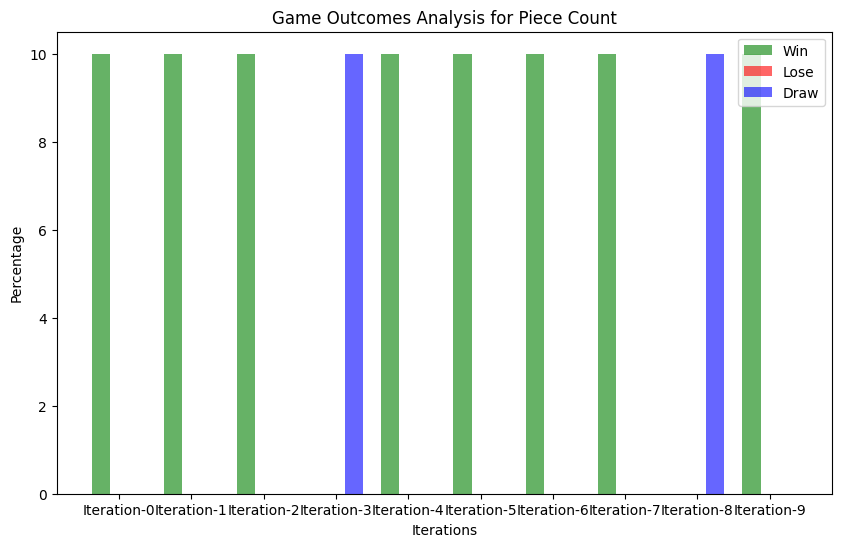

In [13]:
game_outcome(piece_count_wins, piece_count_losses, piece_count_draws, "Piece Count", 10)

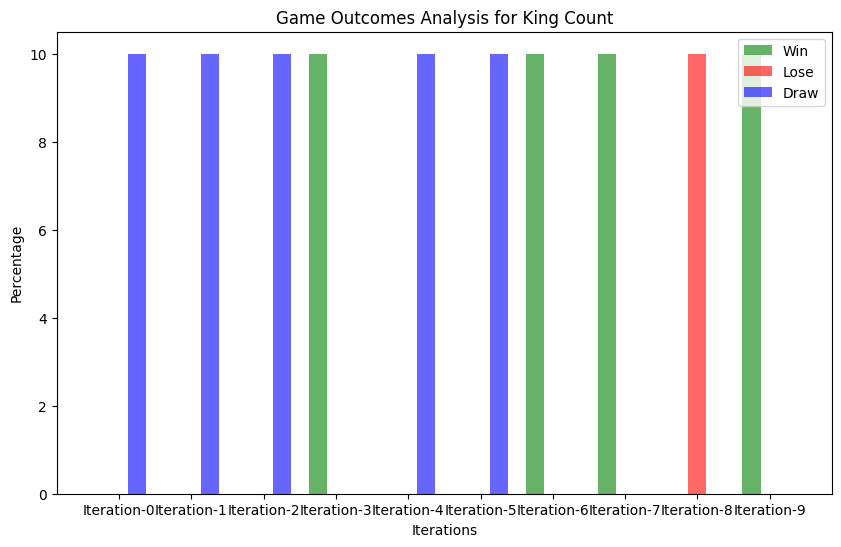

In [14]:
game_outcome(king_count_wins, king_count_losses, king_count_draws, "King Count", 10)

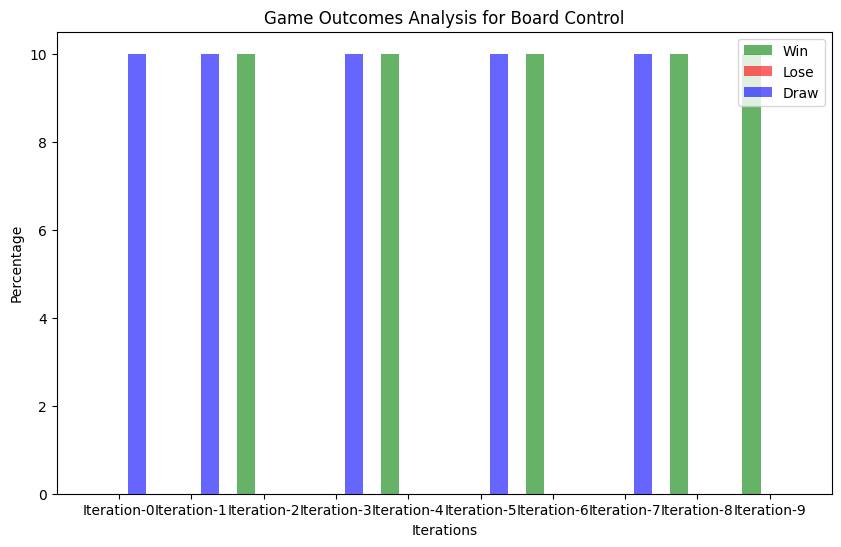

In [12]:
game_outcome(board_control_wins, board_control_losses, board_control_draws, "Board Control", 10)

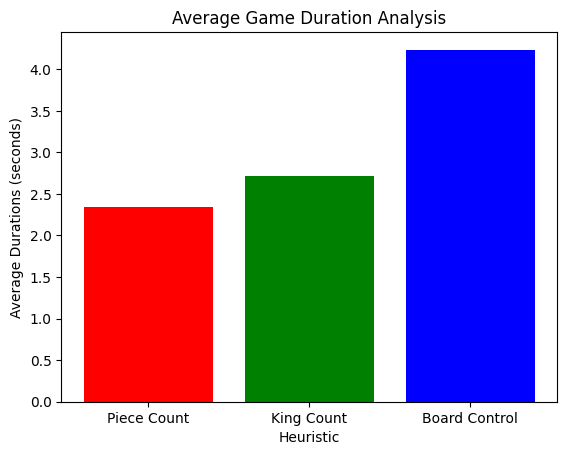

In [10]:
piece_count_average_duration = sum(piece_count_durations) / len(piece_count_durations)
king_count_average_duration = sum(king_count_durations) / len(king_count_durations)
board_control_average_duration = sum(board_control_durations) / len(board_control_durations)

average_durations = [piece_count_average_duration, king_count_average_duration, board_control_average_duration]

heuristics_list = ['Piece Count', 'King Count', 'Board Control']

# Create a bar chart
plt.bar(heuristics_list, average_durations, color=['red', 'green', 'blue'])
plt.xlabel('Heuristic')
plt.ylabel('Average Durations (seconds)')
plt.title('Average Game Duration Analysis')

# Display the plot
plt.show()

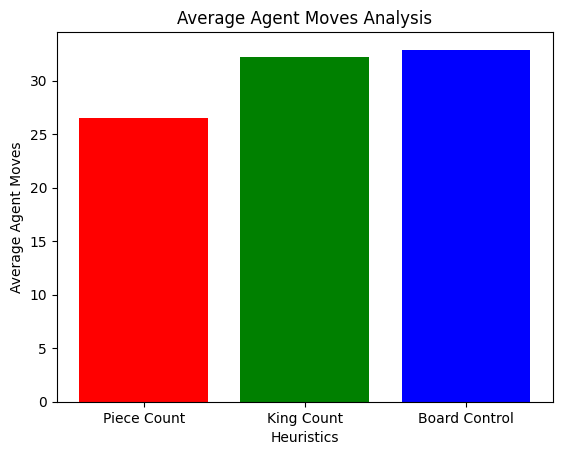

In [11]:
piece_count_average_agent_moves = sum(piece_count_agent_moves) / len(piece_count_agent_moves)
king_count_average_agent_moves = sum(king_count_agent_moves) / len(king_count_agent_moves)
board_control_average_agent_moves = sum(board_control_agent_moves) / len(board_control_agent_moves)

average_agent_moves = [piece_count_average_agent_moves, king_count_average_agent_moves, board_control_average_agent_moves]

# heuristics_list = ['Piece Count', 'King Count', 'Board Control']

# Create a bar chart
plt.bar(heuristics_list, average_agent_moves, color=['red', 'green', 'blue'])
plt.xlabel('Heuristics')
plt.ylabel('Average Agent Moves')
plt.title('Average Agent Moves Analysis')

# Display the plot
plt.show()